In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from biosppy.signals import ecg

%matplotlib notebook

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## HDF Parser
This function will load all data from an HDF and put it into a dictionary, all tables will be pandas DataFrames

In [2]:
def hdf_to_dict(hdf_file):
    # Read all the keys in the file
    with pd.HDFStore(hdf_file, mode='r') as hdf:
        keys = hdf.keys()

    # Read all tables, store in dictionary
    data = {}
    for key in keys: data[key] = pd.read_hdf(hdf_file, key)
    return data

## Load iBeat raw data
This will open the HDF file and load all the keys (tables) into a dictionary

In [3]:
#raw_hdf = '/media/datascience/UCSF/ibeat/Subject044/SE_GENERIC_DATA_EVENT_6671_001/Subject044_Device010_ibeatraw.hdf'
raw_data = hdf_to_dict(raw_hdf)

NameError: name 'raw_hdf' is not defined

The iBeat raw data files have the following keys:
### Optical Data
 * /optical_streams/green/pkg1 - Green (~530nm) PPG signal from optical package (pkg) 1, ~25Hz
 * /optical_streams/green/pkg2 - Green (~530nm) PPG signal from optical packages (pkg) 2, ~50Hz
 * /optical_streams/red/pkg1, /optical_streams/red/pkg2 - Red PPG (~660nm) signal from optical packages 1 and 2, ~25Hz
 * /optical_streams/ir/pkg1, /optical_streams/ir/pkg2 - Infrared PPG (~940nm) signal from optical packages 1 and 2, ~25Hz
 
This data will have the following attributes (columns):
* utc - Universal time epoch (seconds since 1970, GMT)
* pd1 - Raw ADC measurement from package 1 photodiode
* pd2 - Raw ADC measurement from package 2 photodiode
* drive_i - drive current of LED emittor
* gain_value - Analog front end amplifier gain
* pulse_count - Number of pulses averaged for a measurement (will not effect pd1/pd2 count since it is averaged, but will effect signal quiality (SNR)) (real count is 2^(pulse_count))

Note /optica_data is also a key, but it contains the raw stream of optical samples with all wavelengths and packages interleaved, so it is not typically useful for analysis purposes. The streams are build from this data

### Accel data
* /accel_data - Raw accelerometer reading, ~ 25Hz

The data will have the following attributes (columns):
* utc - Universal time epoch (seconds since 1970, GMT)
* x, y, z - Raw measurements from the accelerometer, 4096 counts per G, (+/- 8G sensitivity)

### Contact Data
* /contact_data - Measurements from the metal contact pins on the bottom of device, ~2Hz

The data will have the following attributes (columns):
* utc - Universal time epoch (seconds since 1970, GMT)
* pad1 - Measurement from physical pad 1
* pad2 - Measurement from physical pad 2

The metal contact pin can be used as a fairly reliable boolean for contact. Their base value should be < 600, if making contact with skin, they will read > 800, usually around 2000

### Capacitance Data
* /cap_data - Measurements from the capacitive pads located on the sensorboard, just under bottom housing, ~2Hz

The data will have the following attributes (columns):
* utc - Universal time epoch (seconds since 1970, GMT)
* pad1 - Measurement from physical pad 1
* pad2 - Measurement from physical pad 2

Capacitance data is not as good for a clear binary yes/no that the device is being worn since they have more baseline variation and lower SNR. They are better at sensing the device sitting improperly, but requires some logic (that is taken into account in the contact algorithm)

## Load Algorithm Data

In [4]:

alg_hdf = 'data/Subject016_Device013_04202018_ibeat_alg.hdf'
alg_data = hdf_to_dict(alg_hdf)
alg_df = pd.DataFrame.from_dict(alg_data, orient='index')

ImportError: HDFStore requires PyTables, "No module named tables" problem importing

In [21]:
display(alg_data['/pulse_rate_alg'])

,bpm_raw,bpm_conf,utc,bpm_track
0,220.000000,0.009759,1.524247e+09,NaN
1,220.000000,0.009742,1.524247e+09,NaN
2,220.000000,0.010190,1.524247e+09,NaN
3,220.000000,0.009932,1.524247e+09,NaN
4,220.000000,0.009884,1.524247e+09,NaN
5,220.000000,0.009460,1.524247e+09,NaN
6,127.394958,0.010954,1.524247e+09,NaN
7,138.571429,0.023061,1.524247e+09,NaN
8,135.378151,0.033075,1.524247e+09,NaN
9,135.378151,0.040004,1.524247e+09,NaN


The algorithm HDF contains the following keys:

### Pulse Rate Algorithm
This algorithm was developed to track pulse rate from the PPG signals using a convolutional neural network. 
* /pulse_rate_alg

This will have the following attributes (columns):
* utc - Universal time epoch (seconds since 1970, GMT)
* bpm_raw - Raw output of a convolutional neural network predicting pulse rate - uses a 14 second window with no recurrence. This is simply the pulse rate that corresponds to the max index of the final softmax output
* bpm_conf - This is the value for the max index of the softmax output. Anything less than 0.05 is low, andything above 0.2 is very confident
* bpm_track - This is the output of a simple algorithm logic that uses the raw_bpm, bpm_conf and temporal history to create a more cohesive output. Among other things, it will smooth over noisy outputs and ignore low confidence measurements. This was developed more for activity tracking pulse rate, not necessarily anomolous pulse rate events, and therefor may have trouble tracking some of the data in this study. 

### Contact Algorithm
* /contact_alg

This will have the following attributes (columns):
* utc - Universal time epoch (seconds since 1970, GMT)
* quality - Quality of contact, 0 means no contact, anything above 0.3 is generally okay, but less than 0.6 may indicate the device is sitting unevenly.





## Load UCSF EP Lab Data
This HDF will include all data that was contained in the .txt/.inf files provided by UCSF. Timestamps are added to the datapoints using the following methods:
* utc - This was created using the reported time in the .inf file, assuming a sample rate of 976.9 (which was found to be slighlty more accurate than the 977 reported)
* utc_adjusted - This was the utc value calculated with the .inf file, but with an offset applied according to the timestamp files created by the research coordinators. This timestamp *should* align closely with the ibeat watch UTC values. Not all ecg files contain this, since there were a couple subjects that had missing timestamp alignment files

The functions used to create this file, as well as the time alignment values (copied from the files) is uncluded below for reference

In [75]:
ecg_data_file = '/media/datascience/UCSF_ecg/UCSF/Subject44/Subject44_data.hdf'
ecg_data = pd.read_hdf(ecg_data_file, 'eplab')
print (ecg_data.columns.values)

['ABL' 'ABL Unids' 'ABL d' 'CS 1,2' 'CS 3,4' 'CS 5,6' 'CS 7,8' 'CS 9,10'
 'HIS d' 'HIS m' 'HIS p' 'HRA' 'HRA d' 'I' 'II' 'III' 'RVa' 'RVa d'
 'Stim 1' 'V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'aVF' 'aVL' 'aVR' 'section' 'utc'
 'utc_adjusted']


## Analysis of ECG Data
The following uses the biosppy library to analyze the ECG data for heart rate. Since the data was saved in chunks, the algorithm is run over each chunk individually and concatinated.

In [41]:
## Run ECG Analysis on chunks:
ecg_chunks = []
print('Analyzing {} chunks'.format(len(ecg_data.section.unique())))
for section in ecg_data.section.unique():
    ecg_section = ecg_data[ecg_data.section == section]
    
    # Run biosppy ecg analysis
    ecg_analysis = ecg.ecg(signal=ecg_section.II, sampling_rate=976.942, show=False)
    
    ecg_chunks.append(pd.DataFrame(dict(ecg_heart_rate=ecg_analysis['heart_rate'], 
                                        utc=ecg_analysis['heart_rate_ts'] + ecg_section.utc_adjusted.iloc[0])))

# Concatinate results
ecg_analysis = pd.concat(ecg_chunks)

Analyzing 4 chunks


<IPython.core.display.Javascript object>


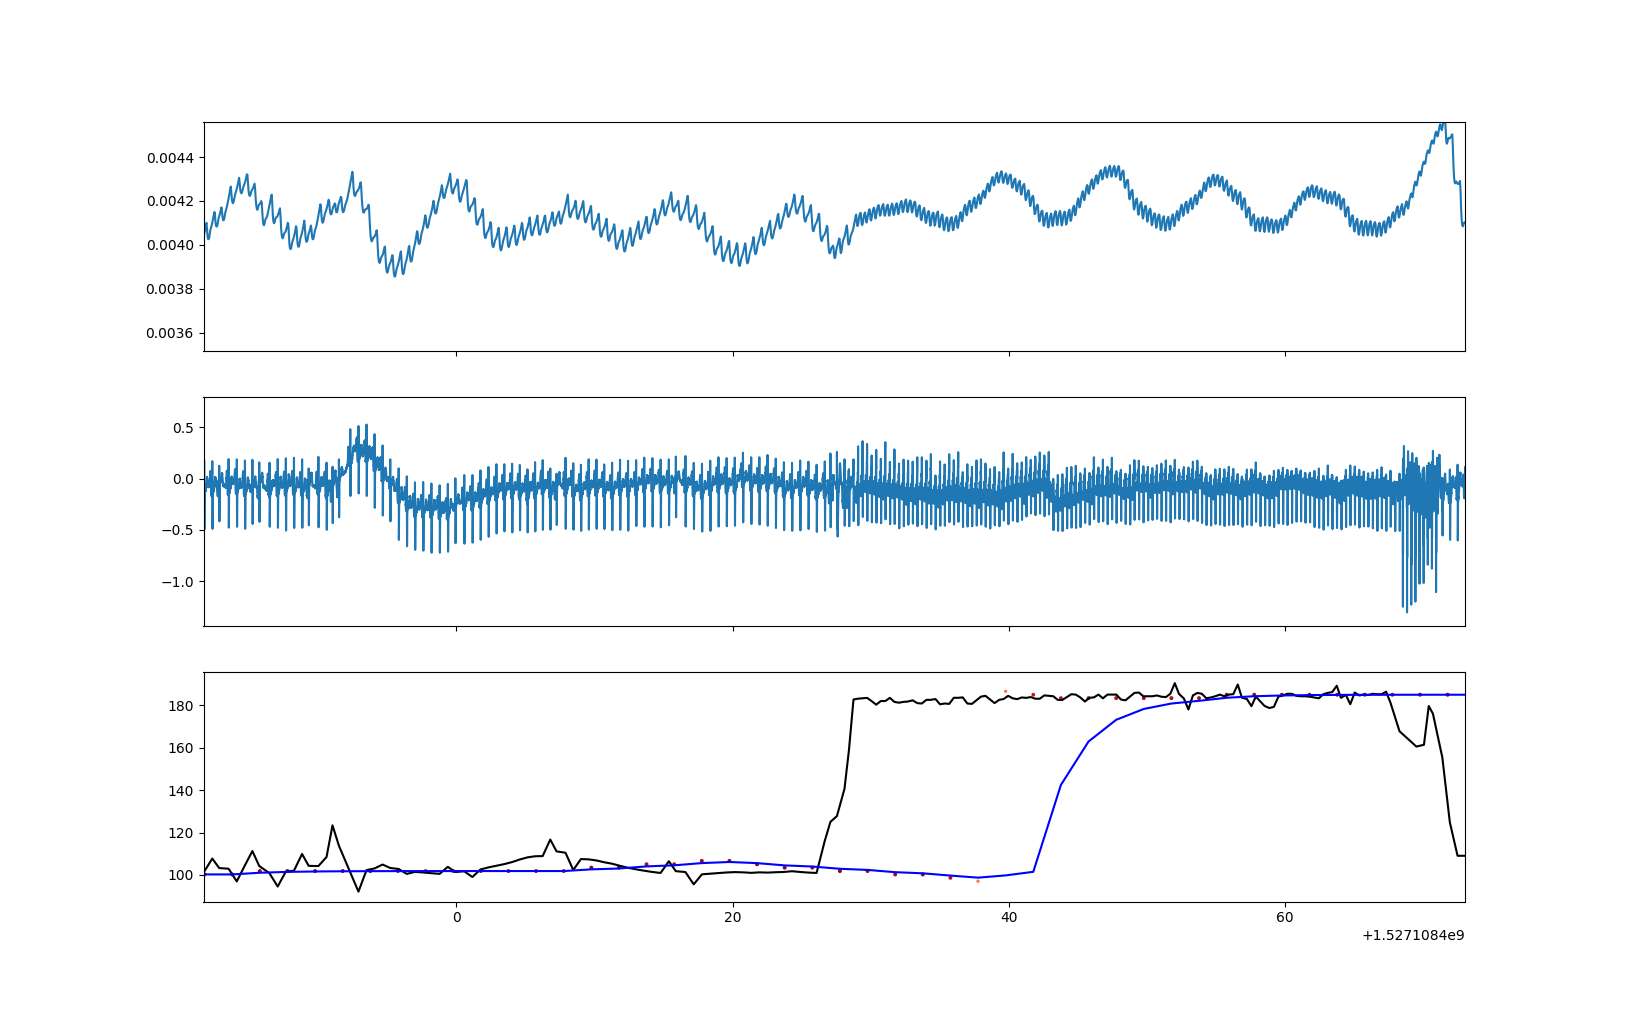

In [78]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(10, 10))

# Raw PPG signal - normalized by drive current and sensor gain
g_pkg1 = raw_data['/optical_streams/green/pkg1']
ax[0].plot(g_pkg1.utc, g_pkg1.pd1 / g_pkg1.drive_i / g_pkg1.gain_value)

# Raw ECG Signal
ax[1].plot(ecg_data.utc_adjusted, ecg_data.II)

# PPG pulse rate and ecg heart rate
ax[2].plot(ecg_analysis.utc, ecg_analysis.ecg_heart_rate, c='k', label='ECG Heart Rate', )
ax[2].plot(alg_data['/pulse_rate_alg'].utc, alg_data['/pulse_rate_alg'].bpm_track, label='PPG Pulse Rate', c='b')

# Plot raw ppg bpm as points, scaled by confidence
ax[2].scatter(alg_data['/pulse_rate_alg'].utc, alg_data['/pulse_rate_alg'].bpm_raw, c=alg_data['/pulse_rate_alg'].bpm_conf, cmap='Reds', s=alg_data['/pulse_rate_alg'].bpm_conf * 20.0)

# ax[-1].set_xlim([ecg_data.utc_adjusted.min(), ecg_data.utc_adjusted.max()])

## Plot iBeat Raw Data
* Filtered PPG - using a high pass FIR with a 0.5 Hz cutoff
* Absorption - Typically us the -log value of the photodiode measurements, normalized by the LED drive current and sensor gain. There is also a 15 second rolling average applied. Note - simply dividing by the drive current is just an approximation that assumes a linear relationship between drive current and output, this is probably accurate for red and IR, but not as much for green.

In [16]:
from scipy import signal
# High pass FIR filter function
def fir_highpass(x, cutoff, order):
    a = signal.firwin(order, cutoff=cutoff, window="hanning")
    # Spectral inversion
    a = -a
    a[int(order / 2)] = a[int(order / 2)] + 1
    return signal.filtfilt(a, [1], x)

/Users/papirobbi/anaconda2/lib/python2.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/papirobbi/anaconda2/lib/python2.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/papirobbi/anaconda2/lib/python2.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

Text(0.5,1,'Contact')

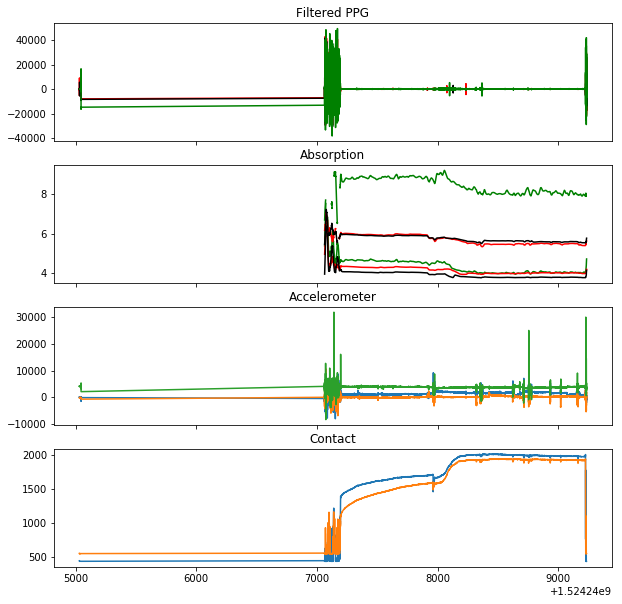

In [17]:
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10, 10))


g_pkg1 = raw_data['/optical_streams/green/pkg1']
r_pkg1 = raw_data['/optical_streams/red/pkg1']
ir_pkg1 = raw_data['/optical_streams/ir/pkg1']

# Filtered PPG signals
ax[0].plot(r_pkg1.utc, fir_highpass(r_pkg1.pd1, 0.5 / (25.0 / 2), 101), 'r')
ax[0].plot(ir_pkg1.utc, fir_highpass(ir_pkg1.pd1, 0.5 / (25.0 / 2), 101), 'k')
ax[0].plot(g_pkg1.utc, fir_highpass(g_pkg1.pd1, 0.5 / (25.0 / 2), 101), 'g')
ax[0].set_title('Filtered PPG')

# Absorption signals
ax[1].plot(g_pkg1.utc, -np.log(g_pkg1.pd1/ g_pkg1.drive_i / g_pkg1.gain_value).rolling(25*15).mean(), 'g')
ax[1].plot(r_pkg1.utc, -np.log(r_pkg1.pd1/ r_pkg1.drive_i / r_pkg1.gain_value).rolling(25*15).mean(), 'r')
ax[1].plot(ir_pkg1.utc, -np.log(ir_pkg1.pd1/ ir_pkg1.drive_i / ir_pkg1.gain_value).rolling(25*15).mean(), 'k')


g_pkg2 = raw_data['/optical_streams/green/pkg2']
r_pkg2 = raw_data['/optical_streams/red/pkg2']
ir_pkg2 = raw_data['/optical_streams/ir/pkg2']
ax[1].plot(g_pkg2.utc, -np.log(g_pkg2.pd1/ g_pkg2.drive_i / g_pkg2.gain_value).rolling(50*15).mean(), 'g')
ax[1].plot(r_pkg2.utc, -np.log(r_pkg2.pd1/ r_pkg2.drive_i / r_pkg2.gain_value).rolling(25*15).mean(), 'r')
ax[1].plot(ir_pkg2.utc, -np.log(ir_pkg2.pd1/ ir_pkg2.drive_i / ir_pkg2.gain_value).rolling(25*15).mean(), 'k')
ax[1].set_title('Absorption')

# Accelerometer
accel = raw_data['/accel_data']
ax[2].plot(accel.utc, accel.x)
ax[2].plot(accel.utc, accel.y)
ax[2].plot(accel.utc, accel.z)
ax[2].set_title('Accelerometer')

# Contact data
contact = raw_data['/contact_data']
ax[3].plot(contact.utc, contact.pad1)
ax[3].plot(contact.utc, contact.pad2)
ax[3].set_title('Contact')

## Code snippets used to generate ecg HDF files

In [ ]:
from datetime import datetime
def get_ecg_data(ecg_info, ecg_data, section=0):
    if os.path.isfile(ecg_info) and os.path.isfile(ecg_data):
        
        # Find timestamps in info file
        data_times = pd.read_table(ecg_info,nrows = 2,header = None,skiprows=6,sep = ' ')
        start_time = int(datetime.strptime(data_times.iloc[0][3] + ' ' + data_times.iloc[0][4] + ' ' + data_times.iloc[0][5], '%m/%d/%Y %I:%M:%S %p').strftime('%s'))
        stop_time = int(datetime.strptime(data_times.iloc[1][3] + ' ' + data_times.iloc[1][4] + ' ' + data_times.iloc[1][5], '%m/%d/%Y %I:%M:%S %p').strftime('%s'))
        
        # Set sample rate
        SR = 976.942
        
        # Read column names from info file
        columns = pd.read_table(ecg_info,sep ='              ', skiprows=9, engine='python')
        columns = [c[0] for c in columns.values]
        
        # Read text file
        data = pd.read_table(ecg_data, delimiter=' ', names=columns, header=None, index_col=False, dtype=np.float32, na_values=['-'])
        
        # Create UTC values
        utcvals = [start_time + 1 / SR * idx for idx in range(data.shape[0])]
        data['utc'] = pd.Series(utcvals)
        
        # Section values can be used to identify contiguous chunks
        data['section'] = pd.Series(np.ones(len(utcvals)) * section)
    else:
        data = None
    return data

def time_from_string(s):
    s = s.split(':')
    return int(s[0])*60*60 + int(s[1])*60 + int(s[2])

def get_all_ecg_data(folder):
    info_files = [f for f in get_all_files_recursive(folder) if '.inf' in f]
    data = [get_ecg_data(info_file, info_file[:-3] + 'txt', idx) for idx, info_file in enumerate(info_files)]
    data = []
    for idx, info_file in enumerate(info_files):
        d = get_ecg_data(info_file, info_file[:-3] + 'txt', idx)
        if d is not None:
            data.append(d)
            
    return pd.concat(data).sort_values(by='utc')

In [ ]:
delta_times = {
    84: ['08:43:39', "8:42:00"],
    83: ['08:19:34', "8:18:00"],
    80: ['14:20:32', "14:18:00"],
    79: ['08:55:18', "08:52:00"],
    78: ['08:23:34', "8:19:00"],
    77: ['08:45:27', "08:43:00"],
    75: ['09:31:51', "9:26:00"],
    73: ['08:55:21', "8:50:00"],
    70: ['08:07:33', "08:04:00"],
    69: ['08:09:23', "08:06:00"],
    67: ['08:36:34', "08:36:00"],
    66: ['07:51:13', "7:48:00"],
    65: ['08:22:23', "08:22:00"],
    63: ['09:00:55', "8:56:00"],
    62: ['09:15:04', "9:15:00"],
    57: ['09:04:04', "09:02:00"],
    56: ['09:01:22', "08:59:00"],
    55: ['08:35:28', "8:33:00"],
    53: ['09:02:35', "09:01:00"],
    52: ['08:58:14', "08:54:00"],
    51: ['08:15:29', "08:14:00"],
    50: ['08:11:46', "08:08:00"],
    49: ['11:04:11', "11:02:00"],
    48: ['07:42:41', "07:39:00"],
    47: ['07:10:15', "10:56:00"],
    44: ['10:54:51', "10:53:00"],
    43: ['12:45:35', "12:42:00"],
    42: ['08:19:45', "8:18:00"],
    41: ['08:01:41', "8:01:00"],
    40: ['08:29:33', "8:26:00"], # Data was saved under subject 39
    39: ['08:29:33', "8:26:00"], # Same as 40
    38: ['07:25:31', "7:29:00"],
    37: ['11:13:41', "11:12:00"],
    33: ['08:15:25', "08:12:00"],
#     32: ['10:17:39', "10:19:00"],
    31: ['08:50:30', "8:47:00"],
    29: ['12:45:28', "12:42:00"],
    27: ['08:28:12', "8:27:00"],
    17: ['08:30:07', "8:31:00"],
    15: ['08:32:11', "08:30:00"],
    13: ['08:06:07', "8:04:00"],
    12: ['08:10:59', "8:10:00"],
    11: ['08:46:17', "8:44:00"],
}